<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Vectorization_and_XLA_compilation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Vectorization_and_XLA_compilation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Statistical Risk Model in Cryptocurrencies

The notebook is to demonstrate the building steps of constructing factor risk models in statistical approach (PCA) in cryptocurrencies. 

Package [factor-pricing-model-risk-model](https://github.com/factorpricingmodel/factor-pricing-model-risk-model) is required in the building steps, while matplotlib is used for visualization.

In [1]:
!pip install matplotlib factor-pricing-model-risk-model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from functools import partial

import numpy as np
import pandas as pd

from IPython.display import display

from fpm_risk_model.dataset.crypto import (
    download_sample_data_estimation_universe,
    download_sample_data_model_universe,
)
from fpm_risk_model.rolling_factor_risk_model import RollingFactorRiskModel
from fpm_risk_model.statistical import PCA
from fpm_risk_model.pipeline import dump_rolling_factor_risk_model, load_rolling_factor_risk_model

# Load top 50 marketcap historical data from Kaggle dataset

The API function `download_sample_data_estimation_universe` downloads the top 50 marketcap historical data from Kaggle [dataset](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrency-historical-prices-coingecko). The price history starts from 2015.


###### Note: The dataset is synchronzed with CoinGecko every day, but due to API keys required in downloading Kaggle data, only the snapshot is provided. 

In [3]:
sample_data_estimation_universe = download_sample_data_estimation_universe()
est_universe_prices = sample_data_estimation_universe["prices"]
est_universe_returns = sample_data_estimation_universe["returns"]
est_universe_volumes = sample_data_estimation_universe["volumes"]
est_universe_marketcap = sample_data_estimation_universe["marketcap"]

# Construct estimation universe

Estimation universe is constructed by selecting the instruments by the following
criteria in the ascending order

1. Active trading for at least 6 months
2. Median of past 6-month daily (absolute) returns should exceed 0.5% (Stablecoin exclusion)
3. Rank the instruments by market cap and exclude the lower rank instruments if they are
   highly correlated with other instruments. (For example, ETH and staked Ether)

A ranking function `correlation_rank_selection` is defined to sort the instruments in rank first, and then select the instruments in ranking order. If the instrument is closely correlated to any instruments selected on the date, it will be excluded.

In [4]:
def correlation_rank_selection(
    d_rank, 
    returns,
    rolling_window=90,
    correlation_threshold=0.9
):
    if d_rank.isnull().all():
        return pd.Series(np.nan, index=d_rank.index)
    ranks = d_rank.sort_values()
    validity = ranks.notnull()
    d_correlations = returns.loc[:d_rank.name, validity].iloc[-rolling_window:].corr()
    selected = []
    for name, i_validity in ranks.items():
        if np.isnan(i_validity):
            continue
        if not selected:
            selected.append(name)
            continue
        if (d_correlations.loc[selected, name].abs() > correlation_threshold).any():
            continue
        selected.append(name)
    valid_instmts = pd.Series(True, index=selected)
    valid_instmts = valid_instmts.reindex(d_rank.index)
    return valid_instmts

<Axes: title={'center': 'Number of valid instruments in universe'}>

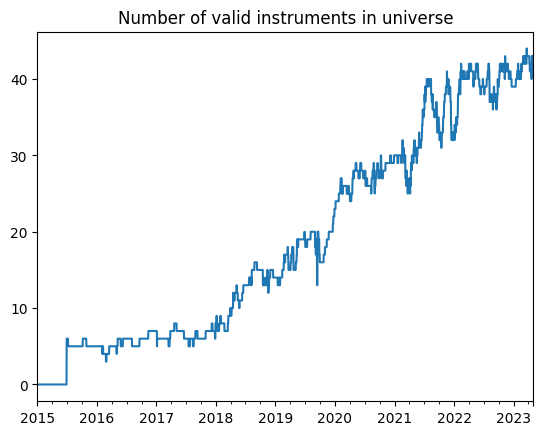

In [5]:
est_universe_validity = (est_universe_marketcap > 0.0).rolling(210, min_periods=180).sum() > 180
est_universe_validity = (
    est_universe_validity & 
    (est_universe_returns.abs().rolling(210, min_periods=180).median() > 0.005)
)
est_universe_marketcap_rank = est_universe_marketcap.where(est_universe_validity).rank(axis=1, ascending=False)
est_universe_validity = (
    est_universe_marketcap_rank.apply(partial(correlation_rank_selection, returns=est_universe_marketcap_rank, rolling_window=90), axis=1)
    .fillna(False)
)
est_universe_validity.index = pd.to_datetime(est_universe_validity.index)
est_universe_validity.sum(axis=1).plot(title="Number of valid instruments in universe")

# Build factor risk model from estimation universe

After defining the scope of estimation universe, we can then compute the factor model with specifying its statistical models. A straightforward approach, [PCA](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/risk_model/statistical/pca.html), is selected to generate the risk model in a rolling window of 180 days. In the meantime, due to the volatile market movement in cryptocurrencies, the daily returns beyond +/-20% is filtered out in running the risk model.

The building steps are as follows.

1. Define PCA model with parameter `n_components`, which can be integers, number of components to keep, or between 0 and 1, the percentage of the amount of variance that needs to be explained. In the example, the value `0.7` means to select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

2. Create an object of rolling factor risk model and define the number of rolling days. Parameter `show_progress` indicates to print the current progress of computation in rolling.

3. Pass the returns and the universe validity into into the `fit` method.

In [6]:
model = PCA(n_components=0.9)
rolling_risk_model = RollingFactorRiskModel(
    window=180,
    model=model,
    show_progress=True,
)
rolling_risk_model.fit(
    est_universe_returns.where(est_universe_returns.abs() < 0.20),
    validity=est_universe_validity,
)  

For example, we can get the correlation matrix from the rolling risk model and see that Bitcoin and Ethereum are 90% correlated.

In [7]:
instruments = ["bitcoin", "ethereum"]
rolling_risk_model.get("2023-04-30").corr().loc[instruments, instruments]

,bitcoin,ethereum
bitcoin,1.000000,0.899209
ethereum,0.899209,1.000000


# Load all crypto OHLCV data

Similarily, he API function `download_sample_data_model_universe` will download a snapshot of model universe data. The data includes 1000 cryptocurrencies since 2014. 

Again, though the dataset is updated in [Kaggle](https://www.kaggle.com/datasets/usamabuttar/cryptocurrency-historical-prices-updated-daily) every day, only a snapshot of dataset is provided here. If you are interested, you can go to the Kaggle site to download the latest one.

Please note that the prices in this dataset is leading that those in the estimation universe one. To align the datetimes between the two sets, all the attributes in model universe are shifted by 1 day.

In [8]:
sample_data_model_universe = download_sample_data_model_universe()
model_universe_prices = sample_data_model_universe["prices"].shift()
model_universe_returns = sample_data_model_universe["returns"].shift()
model_universe_volumes = sample_data_model_universe["volumes"].shift()
model_universe_volumes_usd = model_universe_volumes * model_universe_prices

# Construct model universe

Model universe is constructed by selecting the instruments by the following
criteria in the ascending order

1. Active trading for at least 6 months
2. Median of past 6-month daily (absolute) returns should exceed 0.5% (Stablecoin exclusion)
3. Top 50% average daily volume (rolling 90 day median) among all instruments


<Axes: title={'center': 'Number of valid instruments in universe'}>

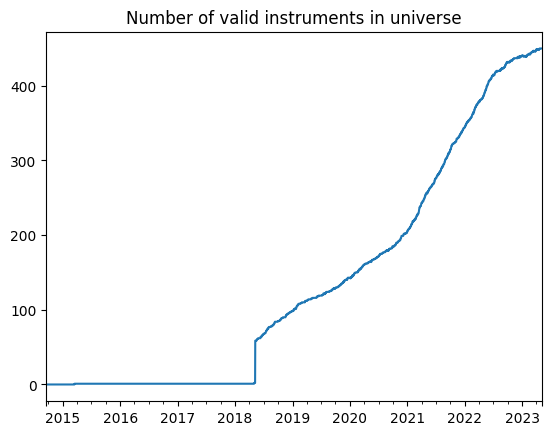

In [9]:
model_universe_validity = (model_universe_volumes > 0.0).rolling(210, min_periods=180).sum() > 180
model_universe_validity = model_universe_validity & (model_universe_returns.abs().rolling(210, min_periods=180).median() > 0.005)
model_universe_volume_usd_rank = (
    model_universe_volumes_usd
    .rolling(90, min_periods=60)
    .median()
    .where(model_universe_validity)
    .rank(axis=1, ascending=False)
)
model_universe_volume_usd_rank = (
    model_universe_volume_usd_rank
    .where(model_universe_volume_usd_rank.lt(model_universe_validity.sum(axis=1) * 0.5, axis=0))
)
model_universe_validity &= model_universe_volume_usd_rank
model_universe_validity.index = pd.to_datetime(model_universe_validity.index)
model_universe_validity.sum(axis=1).plot(title="Number of valid instruments in universe")

# Transform the risk model from estimation to model universe

The transformation reuses the factor returns to compute the new set of factor exposures and idiosyncratic returns on the model universe, even though the instrument names on the two universes are different.

It gives covariance matrix on a much larger number of instruments. For example, in 2023, the number of instruments in estimation and model universes are around 40 and 400 respectively.

In [15]:
rolling_risk_model.transform(
    model_universe_returns.where(model_universe_returns.abs() < 0.2),
    validity=model_universe_validity,
)

# Forecasting accuracy

After the risk model has been transformed into the model universe space, it is important to examine its forecasting accuracy.

In the library, the following methods are provided

1. Bias statistics
2. Value at Risk (VaR)

Both methods require passing the rolling risk model and the portfolio weights. The portfolio weights should be a Dataframe
indicating the instrument weights per date and each date the weights should be summed up to 1. With portfolio weights, 
the portfolio realized volatility, produced by its weights and returns, is compared with the forecast volatility produced
by risk models.

In the following example, an equal weighted portfolio is chosen in the analysis. The bias statistics is computed in a rolling window of 63 days. From the [definition](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/accuracy/bias.html) of bias statistics, the 95% confidence bounds is between 0.82 and 1.17. We can see the bias is sometimes beyond the bounds but oscillate around 1.0. Above 1 means the covariance is underestimated, and vice versa.

<Axes: >

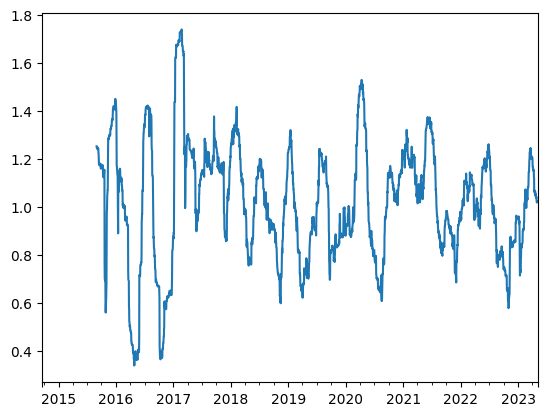

In [20]:
from fpm_risk_model.accuracy import compute_bias_statistics
weights = model_universe_validity.div(model_universe_validity.sum(axis=1), axis=0)
bias_statistics = compute_bias_statistics(
    X=model_universe_returns.where(model_universe_returns.abs() < 0.2),
    weights=weights,
    window=63,
    rolling_risk_model=rolling_risk_model,
)
bias_statistics.plot()

Also, we can compute the VaR statistics with the assumption of equal weighted portfolio. From the [definition](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/accuracy/value_at_risk.html) of VaR breach statistics, it is expected to be within 5%. Rather than suggesting the model overestimates or underestimates the covariance, the breach statistics describes only the two side violation.

<Axes: >

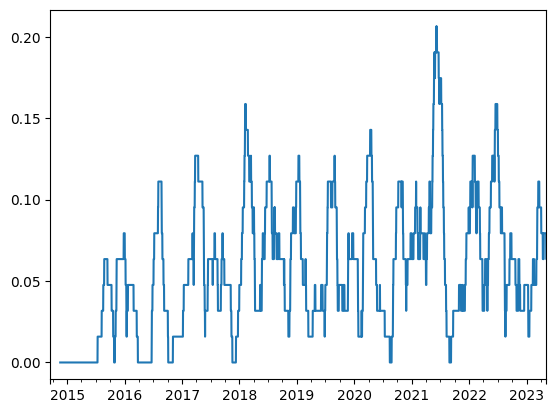

In [19]:
from fpm_risk_model.accuracy import compute_value_at_risk_rolling_breach_statistics
weights = model_universe_validity.div(model_universe_validity.sum(axis=1), axis=0)
var_breach_statistics = compute_value_at_risk_rolling_breach_statistics(
    X=model_universe_returns.where(model_universe_returns.abs() < 0.2),
    weights=weights,
    window=63,
    rolling_risk_model=rolling_risk_model,
)
var_breach_statistics.plot()

For further questions, please do not hesitate to reach out the maintainers of project [factor-pricing-model-risk-model](https://github.com/factorpricingmodel/factor-pricing-model-risk-model). Hope you enjoy it!